In [1]:
import os

import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image

In [2]:
%matplotlib inline

In [3]:
REPO_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
TASK_PATH = os.path.join(REPO_PATH, "tasks", "11-nn.md")
DATA_PATH = '/home/dima/Projects/UD_Ukrainian-IU'

In [4]:
def show_markdown(path):
    with open(path, 'r') as fh:
        content = fh.read()
    display(Markdown(content))

In [5]:
show_markdown(TASK_PATH)

# I. Нейромережі

У цьому завданні вам треба спробувати покращити з використанням нейромереж одну з двох ваших попередніх робіт:

1. Доробити парсер залежностей
2. Доробити класифікатор звернень до служби 1551

## Парсер залежностей

На основі FNN створіть класифікатор типу залежності. Для цього використайте:
- [UD-корпус для української мови](https://github.com/UniversalDependencies/UD_Ukrainian-IU/)
- парсер, який ви розробили в завданні 8 (або, якщо вам не вдалося реалізувати свій парсер, то можна взяти за основу [код із практичного заняття](../lectures/08-dep-parser-uk.ipynb))
- [векторні представлення слів для української мови](http://lang.org.ua/en/models/#anchor4)

Також переробіть свій парсер так, щоб замість використання ознак, визначених вручну, він покладався для вибору наступного переходу на передбачення LSTM-нейромережі, яка на вхід отримує поточні слова з тегами зі стеку та буферу (по 3 слова). Опис подібної мережі можна побачити у [цій статті](https://arxiv.org/pdf/1708.08959.pdf).

Обрахуйте якість класифікації та LAS для вашого парсера.

## Класифікатор звернень до служби 1551

Переробіть класифікатор звернень, який ви розробляли у завданні 10, так, щоб він використовував FNN на векторі документу та LSTM на векторах окремих слів. Порівняйте результати.

# II. Курсовий проєкт

Для свого курсового проєкту побудуйте рішення (чи кілька рішень), що перевершують по якості ваше базове рішення. Якість міряйте розробленими раніше метриками.
Код для курсового проєкту повинен бути у вашому репозиторії. У директорії `students/` в теці з вашим іменем збережіть файл з посиланням на код вашого рішення. Опишіть ваші результати.

# Оцінка

I. За виконання одного з завдань ви можете отримати 80 балів. Якщо бажаєте, то можете виконати обидва і отримати 120 балів :)

II. За покращене рішення з курсового проєкту ви можете отримати 20 балів.


## Dependancy parser

In [6]:
from collections import OrderedDict
from conllu import parse
from enum import Enum

In [7]:
%%time

with open(os.path.join(DATA_PATH, "uk_iu-ud-train.conllu"), "r") as f:
    train_trees = parse(f.read())

with open(os.path.join(DATA_PATH, "uk_iu-ud-dev.conllu"), "r") as f:
    test_trees = parse(f.read())

CPU times: user 3.1 s, sys: 133 ms, total: 3.23 s
Wall time: 3.23 s


In [8]:
print(len(train_trees), len(test_trees))

5496 672


In [9]:
def print_tree(tree):
    for node in tree:
        head = node["head"]
        print("{} <-- {}".format(node["form"],
                             tree[head - 1]["form"]
                             if head > 0 else "root"))

def check_tree(tree):
    for n in tree:
        if not isinstance(n["id"], int):
            return True
    return False

In [10]:
tree = train_trees[0]
print_tree(tree)

У <-- домі
домі <-- була
римського <-- патриція
патриція <-- домі
Руфіна <-- патриція
була <-- root
прегарна <-- фреска
фреска <-- була
, <-- зображення
зображення <-- фреска
Венери <-- зображення
та <-- Адоніса
Адоніса <-- Венери
. <-- була


In [11]:
print("Bad trees: " )
print("Train:", len(list(filter(check_tree, train_trees))))
print("Test:", len(list(filter(check_tree, test_trees))))

Bad trees: 
Train: 197
Test: 16


In [12]:
clean_train_trees = list(filter(lambda t: not check_tree(t), train_trees))
clean_test_trees = list(filter(lambda t: not check_tree(t), test_trees))

print(len(clean_train_trees), len(clean_test_trees))

5299 656


In [13]:
def intersects(n1, n2):
    s1 = n1['id'] if n1['head'] > n1['id'] else n1['head']
    e1 = n1['head'] if n1['head'] > n1['id'] else n1['id']
    s2 = n2['id'] if n2['head'] > n2['id'] else n2['head']
    e2 = n2['head'] if n2['head'] > n2['id'] else n2['id']
    
    return (s1 < s2 and e1 > s2 and e2 > e1) or (s2 < s1 and e2 > s1 and e1 > e2)

def non_projective(tree):
    for n1 in tree:
        for n2 in tree:
            if n1['id'] < n2['id'] and intersects(n1, n2):
                return True
            
    return False

In [14]:
non_projective_train_trees = list(filter(non_projective, clean_train_trees))
non_projective_test_trees = list(filter(non_projective, clean_test_trees))

print(len(non_projective_train_trees), len(non_projective_test_trees))

414 57


In [15]:
np_tree = non_projective_train_trees[21]
print_tree(np_tree)

Звісно <-- було
не <-- було
було <-- root
жодного <-- способу
способу <-- було
дізнатись <-- способу
чи <-- спостерігають
спостерігають <-- дізнатись
за <-- вами
вами <-- спостерігають
саме <-- цей
у <-- проміжок
цей <-- проміжок
проміжок <-- спостерігають
часу <-- проміжок
. <-- було


In [16]:
projective_train_trees = list(filter(lambda t: not non_projective(t), clean_train_trees))
projective_test_trees = list(filter(lambda t: not non_projective(t), clean_test_trees))

print(len(projective_train_trees), len(projective_test_trees))

4885 599


### Design actions and the oracle

In [17]:
class Actions(str, Enum):
    SHIFT = "shift"
    REDUCE = "reduce"
    RIGHT = "right"
    LEFT = "left"

In [18]:
def oracle(stack, top_queue, relations):
    """
    Make a decision on the right action to do.
    """
    top_stack = stack[-1]
    # check if both stack and queue are non-empty
    if top_stack and not top_queue:
        return Actions.REDUCE
    # check if there are any clear dependencies
    elif top_queue["head"] == top_stack["id"]:
        return Actions.RIGHT
    elif top_stack["head"] == top_queue["id"]:
        return Actions.LEFT
    # check if we can reduce the top of the stack
    elif top_stack["id"] in [i[0] for i in relations] and \
         (top_queue["head"] < top_stack["id"] or \
          [s for s in stack if s["head"] == top_queue["id"]]):
        return Actions.REDUCE
    # default option
    else:
        return Actions.SHIFT

In [19]:
ROOT = OrderedDict([('id', 0), ('form', 'ROOT'), ('lemma', 'ROOT'), ('upostag', 'ROOT'),
                    ('xpostag', None), ('feats', None), ('head', None), ('deprel', None),
                    ('deps', None), ('misc', None)])

def trace_actions(tree, log=True):
    """
    Try out the oracle to verify it's returning the right actions.
    """
    stack, queue, relations = [ROOT], tree[:], []
    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        if log:
            print("Stack:", [i["form"]+"_"+str(i["id"]) for i in stack])
            print("Queue:", [i["form"]+"_"+str(i["id"]) for i in queue])
            print("Relations:", relations)
            print(action)
            print("========================")
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()           
        else:
            print("Unknown action.")
    if log:
        print("Gold relations:")
        print([(node["id"], node["head"]) for node in tree])
        print("Retrieved relations:")
        print(sorted(relations))

#### show prohectiva and non-projective trees result

In [20]:
# trace_actions(tree)

In [21]:
# trace_actions(np_tree)

### Feature extraction

In [22]:
import pandas as pd

In [23]:
def extract_features(stack, queue, relations=None):
    
    features = dict()
    
    if len(stack) > 1:        
        features["s0-word"] = stack[-2]["form"]
        features["s0-lemma"] = stack[-2]["lemma"]
        features["s0-tag"] = stack[-2]["upostag"]
#         features["s0-rchildren-num"] = len([r for r in relations if r[1] == stack[-2]['id']])
#         features["s0-lchildren-num"] = len([r for r in relations if r[0] == stack[-2]['id']])
        if stack[-2]["feats"]:
            for k, v in stack[-2]["feats"].items():
                features["s0-" + k] = v
    
    if len(stack) > 2:
        features["s1-word"] = stack[-3]["form"]
        features["s1-tag"] = stack[-3]["upostag"]
    
    if len(stack) > 3:
        features["s2-tag"] = stack[-4]["upostag"]
        
    if len(stack) > 4:
        features["s3-tag"] = stack[-5]["upostag"]
    
    if len(stack) > 1:
        queue_top = stack[-1]
        features["q0-word"] = stack[-1]["form"]
        features["q0-lemma"] = stack[-1]["lemma"]
        features["q0-tag"] = stack[-1]["upostag"]
#         features["q0-rchildren-num"] = len([r for r in relations if r[1] == stack[-1]['id']])
#         features["q0-lchildren-num"] = len([r for r in relations if r[0] == stack[-1]['id']])
        if stack[-1]["feats"]:
            for k, v in stack[-1]["feats"].items():
                features["q0-" + k] = v
    
    if len(queue) > 0:        
        features["q1-word"] = queue[0]["form"]
        features["q1-tag"] = queue[0]["upostag"]
    
    if len(queue) > 1:
        features["q2-tag"] = queue[1]["upostag"]
    
    if len(queue) > 2:
        features["q3-tag"] = queue[2]["upostag"]
       
    if len(stack) > 1:
        features["distance"] = stack[-1]["id"] - stack[-2]["id"]
    
    features['q-empty'] = not bool(queue)    
    
    return features


def extract_features_v2(stack, queue):
    features = dict()
    if len(stack) > 0:
        features["s0-word"] = stack[-1]["form"]
        features["s0-lemma"] = stack[-1]["lemma"]
        features["s0-tag"] = stack[-1]["upostag"]
    if len(stack) > 1:
        features["s1-tag"] = stack[-2]["upostag"]
    if queue:
        queue_top = queue[0]
        features["q0-word"] = queue[0]["form"]
        features["q0-lemma"] = queue[0]["lemma"]
        features["q0-tag"] = queue[0]["upostag"]
    if len(queue) > 1:
        queue_next = queue[1]
        features["q1-word"] = queue[1]["form"]
        features["q1-tag"] = queue[1]["upostag"]
    if len(queue) > 2:
        features["q2-tag"] = queue[2]["upostag"]
    if len(queue) > 3:
        features["q3-tag"] = queue[3]["upostag"]
    return features

In [24]:
def extract_data(tree):
    features, labels = [], []
    stack, queue, relations = [ROOT], tree[:], []

    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        features.append(extract_features(stack, queue))
        labels.append(action.value)
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            stack.append(queue.pop(0))
        else:
            print("Unknown action.")
    return features, labels

#### train data

In [25]:
train_features, train_labels = [], []
for tree in train_trees:
    tree_features, tree_labels = extract_data([t for t in tree if type(t["id"])==int])
    train_features += tree_features
    train_labels += tree_labels

In [26]:
train_df = pd.DataFrame(train_features)
train_df['target'] = train_labels

In [27]:
print(train_df.shape)

(190298, 69)


#### test data

In [28]:
test_features, test_labels = [], []
for tree in test_trees:
    tree_features, tree_labels = extract_data([t for t in tree if type(t["id"])==int])
    test_features += tree_features
    test_labels += tree_labels

In [29]:
test_df = pd.DataFrame(test_features)
test_df['target'] = test_labels

In [30]:
print(test_df.shape)

(25820, 68)


### Train clasifier

In [31]:
RANDOM_STATE = 0
N_COMP = 500

In [32]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *

#### Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
vectorizer = DictVectorizer()
vec = vectorizer.fit(train_features)

print("\nTotal number of features: ", len(vec.get_feature_names()))


Total number of features:  115611


In [35]:
train_features_vectorized = vec.transform(train_features)
test_features_vectorized = vec.transform(test_features)

In [36]:
lr_clf = LogisticRegression(C=2, solver="sag", multi_class="multinomial", max_iter=1000, 
                            verbose=1, random_state=RANDOM_STATE)

In [37]:
lr_pipe = Pipeline([('vec', vec), ('lr_clf', lr_clf)])

In [38]:
# lr_clf.fit(train_features_vectorized, train_labels)
lr_pipe.fit(train_features, train_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 153 seconds


/home/dima/anaconda3/envs/p36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


Pipeline(memory=None,
     steps=[('vec', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('lr_clf', LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='sag',
          tol=0.0001, verbose=1, warm_start=False))])

In [39]:
# predicted = lr_clf.predict(test_features_vectorized)
predicted = lr_pipe.predict(test_features)
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

        left       0.88      0.90      0.89      6371
      reduce       0.86      0.81      0.83      6875
       right       0.77      0.80      0.79      5996
       shift       0.85      0.87      0.86      6578

   micro avg       0.84      0.84      0.84     25820
   macro avg       0.84      0.84      0.84     25820
weighted avg       0.84      0.84      0.84     25820



### Neural networks

In [40]:
import tensorflow as tf
from gensim.models.keyedvectors import KeyedVectors

In [41]:
def extract_features_nn(stack, queue):
    
    features = {
        "s0-lemma": None,
        "s0-tag": None,
        "s1-lemma": None,
        "s1-tag": None,
        "s2-lemma": None,
        "s2-tag": None,
        "q0-lemma": None,
        "q0-tag": None,
        "q1-lemma": None,
        "q1-tag": None,
        "q2-lemma": None,
        "q2-tag": None
    }
    
    if len(stack) > 1:        
        features["s0-lemma"] = stack[-2]["lemma"]
        features["s0-tag"] = stack[-2]["upostag"]
    
    if len(stack) > 2:
        features["s1-lemma"] = stack[-3]["lemma"]
        features["s1-tag"] = stack[-3]["upostag"]
    
    if len(stack) > 3:
        features["s2-lemma"] = stack[-4]["lemma"]
        features["s2-tag"] = stack[-4]["upostag"]
    
    if len(stack) > 1:
        queue_top = stack[-1]
        features["q0-lemma"] = stack[-1]["lemma"]
        features["q0-tag"] = stack[-1]["upostag"]
    
    if len(queue) > 0:        
        features["q1-lemma"] = queue[0]["lemma"]
        features["q1-tag"] = queue[0]["upostag"]
    
    if len(queue) > 1:
        features["q2-lemma"] = queue[1]["lemma"]
        features["q2-tag"] = queue[1]["upostag"]
    
    return features

In [42]:
def extract_data_nn(tree):
    features, labels = [], []
    stack, queue, relations = [ROOT], tree[:], []

    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            features.append(extract_features_nn(stack, queue))
            labels.append(stack[-1]["deprel"])
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            features.append(extract_features_nn(stack, queue))
            labels.append(queue[0]["deprel"])
            stack.append(queue.pop(0))
        else:
            print("Unknown action.")
    return features, labels

In [43]:
w2v_model = KeyedVectors.load_word2vec_format("ubercorpus.lowercased.tokenized.word2vec.300d")

#### Generate features

In [44]:
train_features, train_labels = [], []
for tree in train_trees:
    tree_features, tree_labels = extract_data_nn([t for t in tree if type(t["id"])==int])
    train_features += tree_features
    train_labels += tree_labels

In [45]:
test_features, test_labels = [], []
for tree in test_trees:
    tree_features, tree_labels = extract_data_nn([t for t in tree if type(t["id"])==int])
    test_features += tree_features
    test_labels += tree_labels

In [46]:
def dict2df(feat_dict, labels=None):
    df = pd.DataFrame(feat_dict)
    df.columns = sorted(df.columns)
    if labels:
        df['deprel'] = labels
    return df

In [47]:
train_df = dict2df(train_features, train_labels)
test_df = dict2df(test_features, test_labels)

In [48]:
# train_df.head()
test_df.head()

,q0-lemma,q0-tag,q1-lemma,q1-tag,q2-lemma,q2-tag,s0-lemma,s0-tag,s1-lemma,s1-tag,s2-lemma,s2-tag,deprel
0,дідусь,NOUN,ROOT,ROOT,None,None,",",PUNCT,той,DET,що,SCONJ,punct
1,той,DET,дідусь,NOUN,ROOT,ROOT,що,SCONJ,атестувати,VERB,",",PUNCT,mark
2,дідусь,NOUN,ROOT,ROOT,None,None,той,DET,атестувати,VERB,",",PUNCT,acl:relcl
3,той,DET,дідусь,NOUN,ROOT,ROOT,атестувати,VERB,",",PUNCT,посміхнутися,VERB,punct
4,дідусь,NOUN,ROOT,ROOT,None,None,той,DET,посміхнутися,VERB,й,CCONJ,dislocated


In [49]:
pos_columns = sorted([item for item in train_df.columns if item.endswith('tag')])
# pos_columns

In [50]:
lemma_columns = sorted([item for item in train_df.columns if item.endswith('lemma')])
# lemma_columns

In [51]:
pos_tags = list(sorted(filter(lambda x: isinstance(x, str), set(np.hstack(train_df[pos_columns].values)))))
pos_tags_mapping = dict(zip(pos_tags, range(1, len(pos_tags)+1)))
# pos_tags_mapping

In [52]:
deprel = train_df['deprel'].unique()
deprel_mapping = dict(zip(deprel, range(len(deprel))))
inverse_deprel_mapping = {v:k for k, v in deprel_mapping.items()}
# deprel_mapping

In [53]:
def pos_ohe(x):
    res = np.zeros((1, len(pos_tags_mapping)))
    pos_idx = pos_tags_mapping.get(x)
    if pos_idx:
        res[:,pos_idx-1] = 1
    return res
    
def word_embed(x):
    if x in w2v_model.vocab:
        return w2v_model.__getitem__([x])
    else:
        return np.zeros((1, 300))

In [54]:
def make_nn_features(feats, labels=None):
    df = dict2df(feats, labels)
    
    res = []
    for col in lemma_columns:
        res.append(np.vstack(df[col].fillna('').map(word_embed).values))
    X_lemma = np.stack(res, axis=1)
    
    res = []
    for col in pos_columns:
        res.append(np.vstack(df[col].fillna('').map(pos_ohe).values))
    X_pos = np.stack(res, axis=1)
    
    if labels:
        y = df['deprel'].map(deprel_mapping)
        y = tf.keras.utils.to_categorical(y)
        return X_lemma, X_pos, y
    else:
        return X_lemma, X_pos

In [55]:
X_lemma_train, X_pos_train, y_train = make_nn_features(train_features, train_labels)
X_lemma_test, X_pos_test, y_test = make_nn_features(test_features, test_labels)

print(X_lemma_train.shape, X_pos_train.shape, y_train.shape)

(90880, 6, 300) (90880, 6, 18) (90880, 56)


In [56]:
word_emb_input = tf.keras.layers.Input(shape=X_lemma_train.shape[1:])
pos_emb_input = tf.keras.layers.Input(shape=X_pos_train.shape[1:])

lstm_pos = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(pos_emb_input)
lstm_word = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(word_emb_input)

flat_pos = tf.keras.layers.Flatten()(lstm_pos)
flat_word = tf.keras.layers.Flatten()(lstm_word)

flat_concat = tf.keras.layers.concatenate([flat_pos, flat_word], axis=-1)
# flat = tf.keras.layers.Flatten()(lstm_concat)

flat_concat = tf.keras.layers.Dropout(0.3)(flat_concat)

dense_layer = tf.keras.layers.Dense(128, activation='relu')(flat_concat)

dense_output = tf.keras.layers.Dense(len(deprel_mapping), activation='softmax')(dense_layer)

model = tf.keras.models.Model(inputs=[word_emb_input, pos_emb_input], outputs=dense_output, name='lemma_pos_lstm')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [57]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, verbose=True),
    tf.keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3, verbose=True), 
    tf.keras.callbacks.ModelCheckpoint(filepath='lemma_pos_lstm.h5', save_best_only=True, verbose=True)
]

model.summary()

Model: "lemma_pos_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6, 18)]      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 6, 300)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 6, 128)       42496       input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 6, 128)       186880      input_1[0][0]                    
_____________________________________________________________________________________

In [58]:
history = model.fit(x=[X_lemma_train, X_pos_train], y=y_train,
                    class_weight='balanced',
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_data=([X_lemma_test, X_pos_test], y_test),
                    verbose=1)

Train on 90880 samples, validate on 12367 samples
Epoch 1/100
90720/90880 [============================>.] - ETA: 0s - loss: 0.7200 - categorical_accuracy: 0.7866
Epoch 00001: val_loss improved from inf to 0.54487, saving model to lemma_pos_lstm.h5
90880/90880 [==============================] - 17s 191us/sample - loss: 0.7195 - categorical_accuracy: 0.7866 - val_loss: 0.5449 - val_categorical_accuracy: 0.8251
Epoch 2/100
90624/90880 [============================>.] - ETA: 0s - loss: 0.5099 - categorical_accuracy: 0.8356
Epoch 00002: val_loss improved from 0.54487 to 0.51708, saving model to lemma_pos_lstm.h5
90880/90880 [==============================] - 15s 169us/sample - loss: 0.5101 - categorical_accuracy: 0.8355 - val_loss: 0.5171 - val_categorical_accuracy: 0.8342
Epoch 3/100
90752/90880 [============================>.] - ETA: 0s - loss: 0.4491 - categorical_accuracy: 0.8524
Epoch 00003: val_loss did not improve from 0.51708
90880/90880 [==============================] - 16s 174us

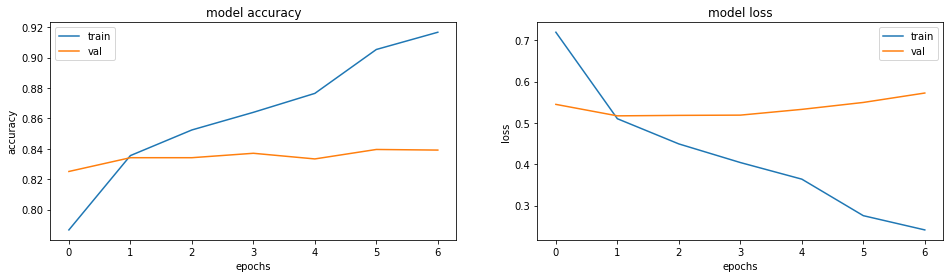

In [59]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [60]:
lemma_pos_lstm_model = tf.keras.models.load_model('lemma_pos_lstm.h5')

In [78]:
pred = lemma_pos_lstm_model.predict([X_lemma_test, X_pos_test])
target_names = list(map(
    lambda x: inverse_deprel_mapping.get(x), 
    sorted(list(set((list(np.argmax(y_test, axis=1)) + list(np.argmax(pred, axis=1))))))
))

print(classification_report(np.argmax(pred, axis=1), 
                            np.argmax(y_test, axis=1),
                            target_names=target_names))

                     precision    recall  f1-score   support

               case       1.00      1.00      1.00      1154
               amod       0.97      0.93      0.95      1065
               nmod       0.93      0.74      0.82      1516
         flat:title       0.51      0.62      0.56       149
                obl       0.57      0.62      0.59       753
               root       1.00      1.00      1.00       647
              nsubj       0.69      0.61      0.65       888
              punct       1.00      1.00      1.00      2359
              appos       0.07      0.21      0.10        28
                 cc       0.98      1.00      0.99       435
               conj       0.38      0.56      0.46       380
             advmod       0.97      0.90      0.93       658
              advcl       0.19      0.49      0.27        45
          discourse       0.89      0.92      0.91       175
              xcomp       0.74      0.76      0.75       111
                obj    

### Calculate the labeled attachment score

In [79]:
from tqdm import tqdm

In [80]:
def dep_parse(sentence, oracle=lr_pipe, deprel_model=lemma_pos_lstm_model, log=False):
    stack, queue, relations = [ROOT], sentence[:], []
    while queue or stack:
        if stack and not queue:
            stack.pop()
        else:
            features_act = extract_features(stack, queue)
            action = oracle.predict(features_act)[0]
            if log:
                print("Stack:", [i["form"]+"_"+str(i["id"]) for i in stack])
                print("Queue:", [i["form"]+"_"+str(i["id"]) for i in queue])
                print("Relations:", relations)
                print(action)
                print("========================")
            # actual parsing
            if action == Actions.SHIFT:
                stack.append(queue.pop(0))
            elif action == Actions.REDUCE:
                stack.pop()
            elif action == Actions.LEFT:
                feat_lemma, feat_pos = make_nn_features([extract_features_nn(stack, queue)])
                deprel_pred = inverse_deprel_mapping.get(
                    np.argmax(deprel_model.predict([feat_lemma, feat_pos]))
                )
                relations.append((stack[-1]["id"], queue[0]["id"], deprel_pred))
                stack.pop()
            elif action == Actions.RIGHT:
                feat_lemma, feat_pos = make_nn_features([extract_features_nn(stack, queue)])
                deprel_pred = inverse_deprel_mapping.get(
                    np.argmax(deprel_model.predict([feat_lemma, feat_pos]))
                )
                relations.append((queue[0]["id"], stack[-1]["id"], deprel_pred))
                stack.append(queue.pop(0))
            else:
                print("Unknown action.")
    return sorted(relations)

In [81]:
total, tp = 0, 0
for tree in tqdm(test_trees):
    tree = [t for t in tree if type(t["id"])==int]
    golden = [(node["id"], node["head"], node["deprel"]) for node in tree]
    predicted = dep_parse(tree, lr_pipe, lemma_pos_lstm_model)
    total += len(tree)
    tp += len(set(golden).intersection(set(predicted)))

print("Total:", total)
print("Correctly defined:", tp)
print("LAS:", round(tp/total, 2))

100%|██████████| 672/672 [05:07<00:00,  2.19it/s]

Total: 12574
Correctly defined: 7717
LAS: 0.61
